<a href="https://colab.research.google.com/github/IgorBaratta/wave-direction/blob/master/notebooks/generate_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Imports
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
from scipy.special import hankel1

In [0]:
N = 101
u = numpy.linspace(-1, 1, N)
v = numpy.linspace(-1, 1, N) 
U, V = numpy.meshgrid(u, v)
X = numpy.hstack((U.reshape((N**2, 1)), V.reshape((N**2, 1))))

omega = 2*numpy.pi  # frequency

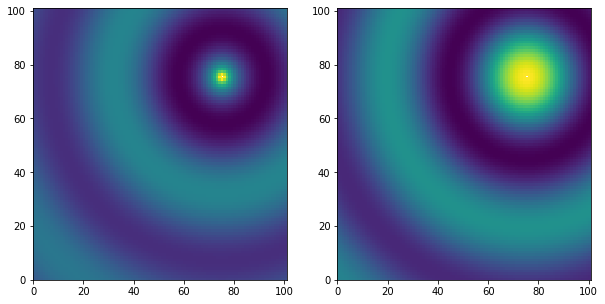

In [4]:
x0 = numpy.array([0.5, 0.5])
field = numpy.zeros(N**2, dtype=numpy.complex128)
dist = numpy.sqrt(numpy.sum((X - x0)**2, axis=1))
field += 1j/4*numpy.sqrt(omega)*hankel1(0, omega*dist)
field = field.reshape(N, N)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].pcolor(field.real)
ax[1].pcolor(field.imag)

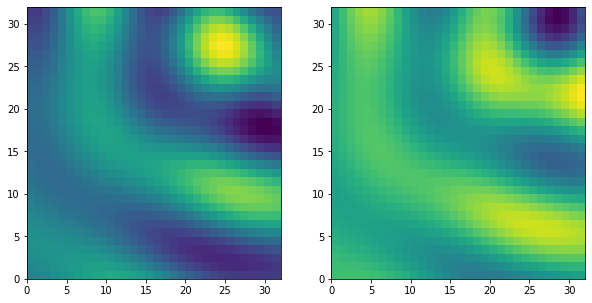

In [58]:
## Generate plane wave from point sources:

Npoints = 5
x0 = numpy.vstack((2 *numpy.random.rand(Npoints), 2 * numpy.random.rand(Npoints))).T
field = numpy.zeros(N**2, dtype=numpy.complex128)

# TODO: vectorize this:
for x in x0:
  dist = numpy.sqrt(numpy.sum((X - x)**2, axis=1))
  field += 1j/4*numpy.sqrt(omega)*hankel1(0, omega*dist)

field = field.reshape(N, N)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].pcolor(field.real)
ax[1].pcolor(field.imag)

In [0]:
N = 32
u = numpy.linspace(-1, 1, N)
v = numpy.linspace(-1, 1, N) 
U, V = numpy.meshgrid(u, v)
X = numpy.hstack((U.reshape((N**2, 1)), V.reshape((N**2, 1))))

omega = 10*numpy.pi  # frequency

def calculate_field(x0):
  field = numpy.zeros(N**2, dtype=numpy.complex128)
  dist = numpy.sqrt(numpy.sum((X - x0)**2, axis=1))
  field += 1j/4*numpy.sqrt(omega)*hankel1(0, omega*dist)
  field = field.reshape(N, N)
  return field

def generate_data(num_samples, N):
  # N is the height and width of the image
  # generate data with num_sample samples
  x = (numpy.random.rand(num_samples, 2) - 0.5) * 10
  img_input = numpy.zeros((num_samples, N, N, 2))
  label = numpy.zeros(num_samples)
  for i in range(num_samples):
    field = calculate_field(x[i])
    img_input[i,:,:,0] = field.real
    img_input[i,:,:,1] = field.imag
    label[i] = ((math.atan2(-x[i][1],-x[i][0]) + 2*numpy.pi) * 180/numpy.pi) % 360 
  return img_input, label




Estimated angle: 96.06406959074758


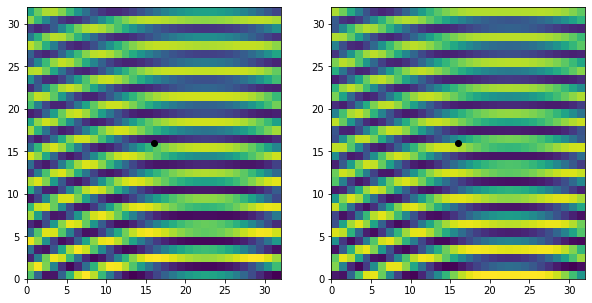

In [6]:
import math
# Number of samples:
training_size = 5000
test_size = 200

train_input, train_label = generate_data(training_size, N)
train_label = train_label/ 360
test_input, test_label = generate_data(test_size, N)
test_label = test_label/ 360

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].pcolor(train_input[0,:,:,0])
ax[0].plot(N/2, N/2, 'ko')
ax[1].pcolor(train_input[0,:,:,1])
ax[1].plot(N/2, N/2, 'ko')

print("Estimated angle:",  train_label[0]*360)

(0.0, 390.0)

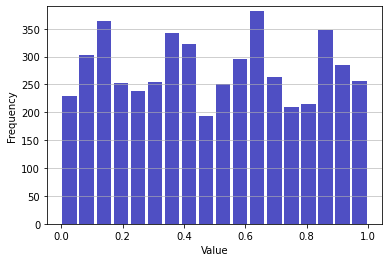

In [7]:
hist, bin_edges = numpy.histogram(train_label)

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=train_label, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=numpy.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [21]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
print(tf.__version__)

2.2.0-rc3


In [29]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(N, N, 2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.InputLayer(input_shape=(N, N, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Display archictecture
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 30, 30, 64)        1216      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               590080    
_________________________________________________________________
dense_22 (Dense)             (None, 64)               

In [30]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.MeanAbsoluteError())

history = model.fit(train_input, train_label, epochs=100, 
                    validation_data=(test_input, test_label))


Epoch 1/100
157/157 [==============================] - 11s 69ms/step - loss: 0.1008 - val_loss: 0.0431
Epoch 2/100
157/157 [==============================] - 11s 68ms/step - loss: 0.0380 - val_loss: 0.0304
Epoch 3/100
157/157 [==============================] - 11s 69ms/step - loss: 0.0321 - val_loss: 0.0236
Epoch 4/100
157/157 [==============================] - 11s 69ms/step - loss: 0.0281 - val_loss: 0.0196
Epoch 5/100
157/157 [==============================] - 11s 69ms/step - loss: 0.0235 - val_loss: 0.0175
Epoch 6/100
157/157 [==============================] - 11s 69ms/step - loss: 0.0214 - val_loss: 0.0145
Epoch 7/100
157/157 [==============================] - 11s 69ms/step - loss: 0.0196 - val_loss: 0.0136
Epoch 8/100
157/157 [==============================] - 11s 69ms/step - loss: 0.0163 - val_loss: 0.0164
Epoch 9/100
157/157 [==============================] - 11s 68ms/step - loss: 0.0154 - val_loss: 0.0112
Epoch 10/100
157/157 [==============================] - 11s 69ms/step - l

7/7 - 0s - loss: 0.0011
0.4062909632921219


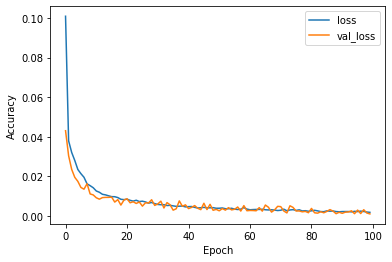

In [31]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0, 1])
plt.legend(loc='upper right')

test_label = test_label.reshape(test_size, 1)
test_loss = model.evaluate(test_input,  test_label, verbose=2)
print(test_loss*360)
direction = model.predict(test_input)
# print(numpy.hstack((direction, test_label))*360) 

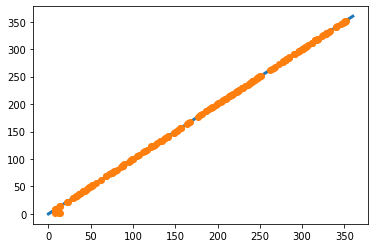

In [32]:
prf = numpy.linspace(0, 360, 100)
plt.plot(prf, prf, linewidth=3)
plt.plot(direction*360, test_label*360, 'o')
